# Mask R-CNN - Train on Nuclei Dataset (updated from train_shape.ipynb)


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 



In [1]:
import os
import sys
import random
import math
import re
import time
import tqdm
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = "/data2/liangfeng/nuclei_models"
DATA_DIR = os.path.join(ROOT_DIR, "data")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "models", "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/liangf/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Configurations

In [2]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAIN

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Load the nuclei dataset

Extend the Dataset class and add a method to get the nuclei dataset, `load_image_info()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class NucleiDataset(utils.Dataset):

    """Load the images and masks from dataset."""

    def load_image_info(self, set_path):
        """Get the picture names(ids) of the dataset."""
        
        # Add classes
        self.add_class("nucleis", 1, "regular")
        # TO DO : Three different image types into three classes
        
        # Add images
        # Get the images ids of training/testing set
        train_ids = next(os.walk(set_path))[1]
        # Get the info of the images
        for i, id_ in enumerate(train_ids):
            file_path = os.path.join(set_path, id_)
            img_path = os.path.join(file_path, "images")
            masks_path = os.path.join(file_path, "masks")
            img_name = id_ + ".png"
            img = cv2.imread(os.path.join(img_path, img_name))
            width, height, _ = img.shape
            self.add_image("nucleis", image_id=id_, path=file_path,
                           img_path=img_path, masks_path=masks_path,
                           width=width, height=height,
                           nucleis="nucleis")                

    def load_image(self, image_id):
        """Load image from file of the given image ID."""
        info = self.image_info[image_id]
        img_path = info["img_path"]
        img_name = info["id"] + ".png"
        image = cv2.imread(os.path.join(img_path, img_name))
        return image

    def image_reference(self, image_id):
        """Return the path of the given image ID."""
        info = self.image_info[image_id]
        if info["source"] == "nucleis":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Load the instance masks of the given image ID."""
        info = self.image_info[image_id]
        mask_files = next(os.walk(info["masks_path"]))[2]
        masks = np. zeros([info['width'], info['height'], len(mask_files)], dtype=np.uint8)
        for i, id_ in enumerate(mask_files):
            single_mask = cv2.imread(os.path.join(info["masks_path"], id_), 0)
            masks[:, :, i:i+1] = single_mask[:, :, np.newaxis]
        class_ids = np.ones(len(mask_files))
        return masks, class_ids.astype(np.int32)


In [5]:
# Training dataset
TRAINSET_DIR = os.path.join(DATA_DIR, "stage1_train")
VALSET_DIR = os.path.join(DATA_DIR, "stage1_val")
# TESTSET_DIR = os.path.join(DATA_DIR, "stage1_test")

dataset_train = NucleiDataset()
dataset_train.load_image_info(TRAINSET_DIR)
dataset_train.prepare()

dataset_val = NucleiDataset()
dataset_val.load_image_info(VALSET_DIR)
dataset_val.prepare()

print("Loading {} training images, {} validation images"
      .format(len(dataset_train.image_ids), len(dataset_val.image_ids)))

Loading 603 training images, 67 validation images


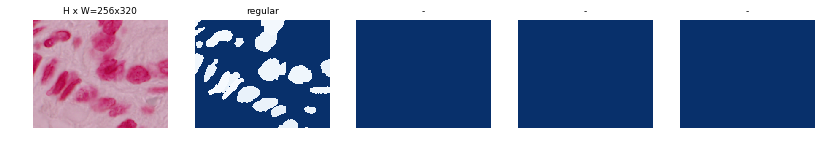

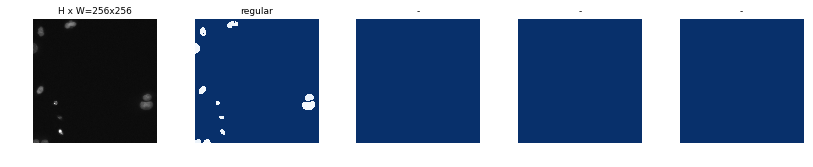

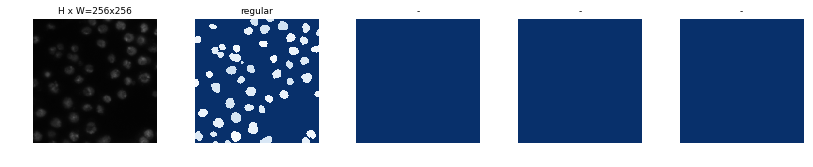

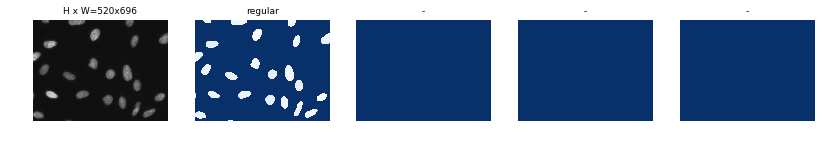

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for i, image_id in enumerate(image_ids):
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Bounding Boxes

Although we don't have the specific box coordinates in the dataset, we can compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  34 /home/liangf/IVision/Mask_RCNN/data/stage1_train/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81
image                    shape: (603, 1272, 3)        min:    0.00000  max:  156.00000
mask                     shape: (603, 1272, 199)      min:    0.00000  max:  255.00000
class_ids                shape: (199,)                min:    1.00000  max:    1.00000
bbox                     shape: (199, 4)              min:   48.00000  max:  951.00000


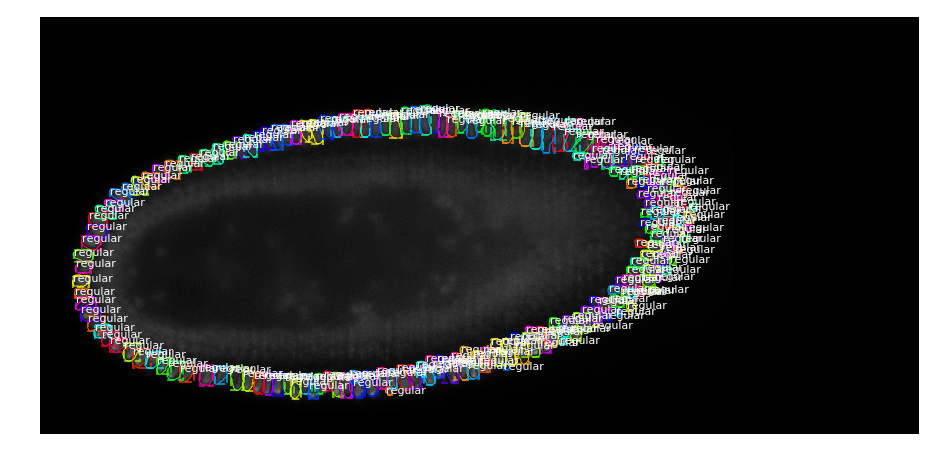

In [15]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [17]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/liangf/IVision/Mask_RCNN/logs/nuclei20180202T1533/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
m

/home/liangf/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/liangf/anaconda2/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 672s 7s/step - loss: 2.2158 - rpn_class_loss: 0.2471 - rpn_bbox_loss: 0.8937 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.4155 - val_loss: 1.5953 - val_rpn_class_loss: 0.0915 - val_rpn_bbox_loss: 0.7617 - val_mrcnn_class_loss: 0.1987 - val_mrcnn_bbox_loss: 0.2487 - val_mrcnn_mask_loss: 0.2946


In [18]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/liangf/IVision/Mask_RCNN/logs/shapes20180131T1458/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


/home/liangf/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/liangf/anaconda2/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 118s 1s/step - loss: 0.9624 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.1566 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.2520 - val_loss: 0.9021 - val_rpn_class_loss: 0.0132 - val_rpn_bbox_loss: 0.4458 - val_mrcnn_class_loss: 0.1439 - val_mrcnn_bbox_loss: 0.0954 - val_mrcnn_mask_loss: 0.2038


In [19]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection Example

In [6]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_NMS_THRESHOLD = 0.3
    DETECTION_MAX_INSTANCES = 300

inference_config = InferenceConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "/data2/liangfeng/nuclei_models/nuclei20180202T1847/mask_rcnn_nuclei_0080.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /data2/liangfeng/nuclei_models/nuclei20180202T1847/mask_rcnn_nuclei_0080.h5


In [12]:
# Test on a random image(load_image_gt will resize the image!)
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
print("image_id ", image_id, dataset_val.image_reference(image_id))
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

NameError: name 'dataset_val' is not defined

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  232.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  128.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


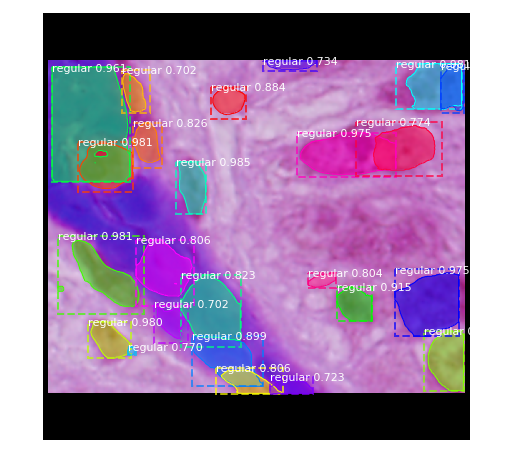

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
# print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [10]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 10)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.808316577444


## Writing the Results

In [8]:
# Get the Test set.
TESTSET_DIR = os.path.join(DATA_DIR, "stage1_test")
dataset_test = NucleiDataset()
dataset_test.load_image_info(TESTSET_DIR)
dataset_test.prepare()

print("Predict {} images".format(dataset_test.num_images))

Predict 65 images


(-0.5, 252.5, 518.5, -0.5)

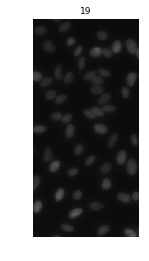

In [43]:
# Load random image and mask(Original Size).
image_id = np.random.choice(dataset_test.image_ids)

image = dataset_test.load_image(image_id)

plt.figure() 
plt.imshow(image)
plt.title(image_id, fontsize=9)
plt.axis('off')

# images = dataset_test.load_image(image_ids)
# mask, class_ids = dataset_test.load_mask(image_id)
# Compute Bounding box
# bbox = utils.extract_bboxes(mask)

# Display image and additional stats
# print("image_id ", image_id, dataset_test.image_reference(image_id))

# log("image", image)
# log("mask", mask)
# log("class_ids", class_ids)
# log("bbox", bbox)
# Display image and instances
# visualize.display_instances(image, bbox, mask, class_ids, dataset_test.class_names)

Processing 1 images
image                    shape: (519, 253, 3)         min:    9.00000  max:  101.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   -3.90000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(array([], dtype=int64), array([], dtype=int64))
(array([211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212,
       212, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 215, 215,
       215, 215, 215, 215, 216, 216, 216, 216, 216, 216, 217, 217, 217,
       217, 217, 217, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219,
       219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220,
       220, 221, 221, 221, 221, 221, 221, 222, 222, 223, 223, 223, 223,
       223, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 226, 226,
       226, 226, 226, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228,
       228, 229, 229, 229, 229, 229, 229, 230, 230, 230, 230, 230, 231,
       231, 231, 231,

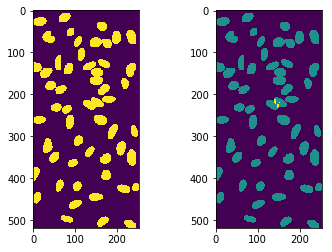

In [66]:
results = model.detect([image], verbose=1)
r = results[0]
mask_exist = np.zeros(r['masks'].shape[:-1], dtype=np.uint8)
mask_sum = np.zeros(r['masks'].shape[:-1], dtype=np.uint8)
for i in range(r['masks'].shape[-1]):
    _mask = r['masks'][:,:,i]
    mask_sum += _mask
#     print(np.multiply(mask_exist, _mask))
#     print(np.where(np.multiply(mask_exist, _mask) == 1))
    index_ = np.where(np.multiply(mask_exist, _mask) == 1)
    _mask[index_] = 0
    mask_exist += _mask
    
    
    
# masks_sum = np.sum(r['masks'] ,axis=2)

# overlap = np.where(masks_sum > 1)
# print(overlap)
# plt.figure() 
plt.subplot(1,2,1)
plt.imshow(mask_exist)
plt.subplot(1,2,2)
plt.imshow(mask_sum)
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_test.class_names, r['scores'], ax=get_ax())

In [68]:
a = [[0, 1],[0, 0]]
np.any(a)

True

In [74]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
import pandas as pd

test_ids = []
test_rles = []

id_ = dataset_val.image_info[image_id]["id"]
results = model.detect([image], verbose=1)
r = results[0]

for i in range(len(r['scores'])):
    test_ids.append(id_)
    test_rles.append(rle_encoding(r['masks'][:, : , i]))

sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(test_rles).apply(lambda x: ' '.join(str(y) for y in x))
model_path
csvpath = "{}.csv".format(model_path)
print(csvpath)
sub.to_csv(csvpath, index=False)
# plt.imshow('image',r['masks'][0])


Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  912.00000
/data2/liangfeng/nuclei_models/nuclei20180202T1847/mask_rcnn_nuclei_0040.h5.csv
